# Ensemble Learning and Random Forests
*This is a notebook about ensemble learning and random forests*

## SETUP

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "chapter7_ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [29]:
# Extra modules imported during the work
from sklearn.datasets import make_moons
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

## Voting Classifiers

In [3]:
# Biased coin tosses
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


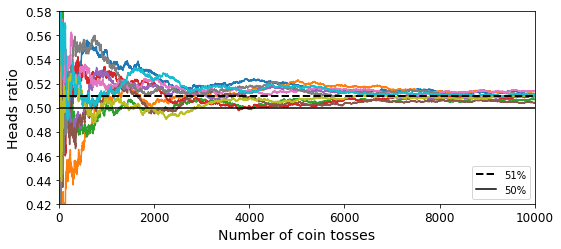

In [4]:
# The law of large number
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [5]:
# Load moon dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
# Train a Voting clf (hard) composed of three different models
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
# Check the accuracy on the test set
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [8]:
# Train a Voting clf (soft) composed of three different models
proba_svm_clf = SVC(gamma="scale", random_state=42, probability=True) # turn predict_proba on

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', proba_svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [9]:
# Check the accuracy on the test set
for clf in (log_clf, rnd_clf, proba_svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging and Pasting

### Bagging and Pasting in Scikit-Learn

In [10]:
# Train a bagging ensemble of Decision Trees
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

**Remark:** 
- 500 Decision Tree classifiers & 100 training instances each Decision Trees
- `bootstrap=True` means bagging technique (with replacement) is used and vice versa

In [11]:
# Train a single Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred_tree)

0.856

In [12]:
# Setup to plot Decision boundary of the Decision Tree vs the Bagging Ensemble 
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


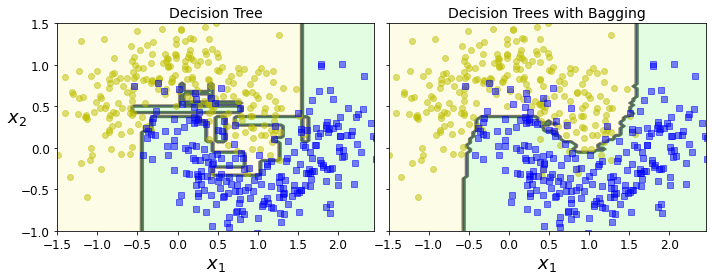

In [13]:
# Plot Decision boundary of the Decision Tree vs the Bagging Ensemble 
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### Out-of-Bag Evaluation

In [14]:
# Request an automatic obb evaluation after the bagging ensemble training
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [15]:
# Check the accuracy on the test set 
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [16]:
# Show the obb decision function
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

**Evaluate:** The oob evaluation estimates that the first training instance has a 68.25% probability of belonging to the positive class, and vice versa

## Random Patches and Random Subspaces

## Random Forests

In [18]:
# Train a Random Forest clf
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [19]:
# Train a bagging ensemble of Decision Tress
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

In [20]:
# Compare the results of the two models
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

### Extra-Trees

In [22]:
ext_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
ext_clf.fit(X_train, y_train)

y_pred_ext = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_ext)

0.912

### Feature Importance

In [24]:
# Feature importance of iris dataset based on Random Forest clf
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [26]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [27]:
# Train a Random Forest clf for MNIST dataset
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

Saving figure mnist_feature_importance_plot


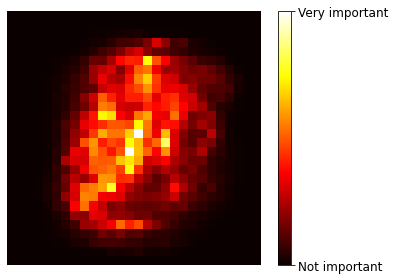

In [28]:
# Plot MNIST pixel importance
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

## Boosting

### AdaBoost

In [30]:
# Train a AdaBoost clf
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
accuracy_score(y_test, ada_clf.predict(X_test))

0.896

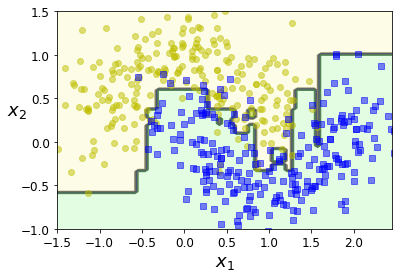

In [31]:
# Plot decision boundary of AdaBoost clf 
plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


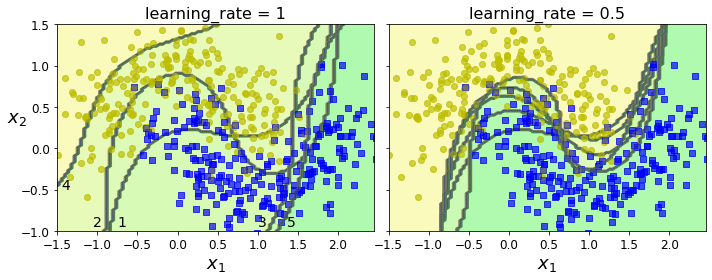

In [32]:
# Plot decision boundaries of consecutice predictors
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()